In [57]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [58]:
#make the original data
series = np.sin((0.1*np.arange(400))**2)

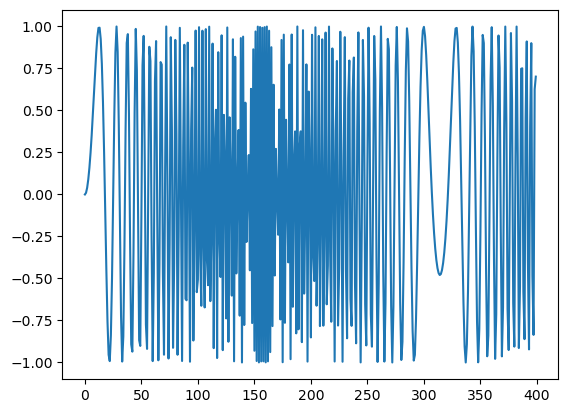

In [59]:
#plot it
plt.plot(series)
plt.show()  

In [95]:
#build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1,1)
N= len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [96]:
#Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [123]:
#Define RNN
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        #note: batch_first=True
        #applies the convention that our data will be of shape:
        # (num_samples , sequence_length, num_features)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)
    def forward(self, X):
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        #get RNN unit output
        #out is of size (N,T,M)
        #2nd return value is hidden states at each hidden layes
        out,_ = self.rnn(X,(h0,c0))

        #we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

In [124]:
#Instantiate the model
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs =1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [125]:
#Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [126]:
#Make inputs and targets
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [127]:
#Training
def full_gd(model, criterion,optimizer,X_train,y_train,X_test,y_test, epochs = 200):
    #Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        #zeros the parameter gradient
        optimizer.zero_grad()
        #forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        #backward and optimize
        loss.backward()
        optimizer.step()

        #Save losses
        train_losses[it] = loss.item()

        #Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it+1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')
    return train_losses , test_losses

In [128]:
#move the above data to cpu
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [129]:
train_losses, test_losses = full_gd(
    model, criterion, optimizer, X_train, y_train,X_test, y_test
)

Epoch 5/200, Train Loss: 0.5151, Test Loss: 0.5116
Epoch 10/200, Train Loss: 0.4959, Test Loss: 0.6358
Epoch 15/200, Train Loss: 0.4791, Test Loss: 0.6077
Epoch 20/200, Train Loss: 0.4182, Test Loss: 0.5243
Epoch 25/200, Train Loss: 0.2474, Test Loss: 0.2962
Epoch 30/200, Train Loss: 0.0925, Test Loss: 0.1581
Epoch 35/200, Train Loss: 0.0573, Test Loss: 0.1420
Epoch 40/200, Train Loss: 0.0340, Test Loss: 0.0809
Epoch 45/200, Train Loss: 0.0232, Test Loss: 0.0502
Epoch 50/200, Train Loss: 0.0171, Test Loss: 0.0324
Epoch 55/200, Train Loss: 0.0123, Test Loss: 0.0281
Epoch 60/200, Train Loss: 0.0098, Test Loss: 0.0258
Epoch 65/200, Train Loss: 0.0072, Test Loss: 0.0232
Epoch 70/200, Train Loss: 0.0053, Test Loss: 0.0237
Epoch 75/200, Train Loss: 0.0042, Test Loss: 0.0236
Epoch 80/200, Train Loss: 0.0033, Test Loss: 0.0237
Epoch 85/200, Train Loss: 0.0027, Test Loss: 0.0243
Epoch 90/200, Train Loss: 0.0022, Test Loss: 0.0226
Epoch 95/200, Train Loss: 0.0031, Test Loss: 0.0202
Epoch 100/200

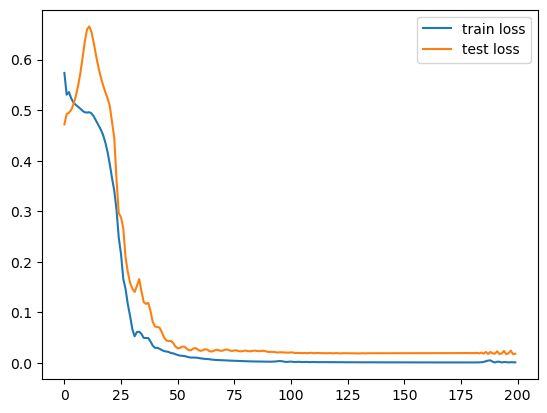

In [130]:
#plot the train loss and test loss
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [131]:
#one-step forecast using true targets
#note: even the one-step fprecast fails badly
validation_target = Y[-N//2:]
validation_predictions = []

#index of first validation input
i = 0
while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1,T,1)
    p = model(input_)[0,0].item()
    i += 1
    #update the predictions list
    validation_predictions.append(p)

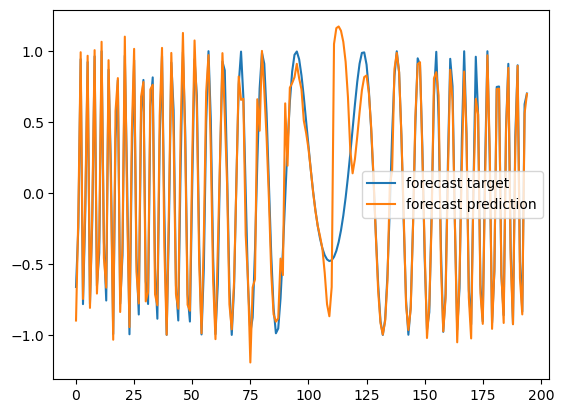

In [106]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [132]:
#multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

#last train_input
last_x = X_test[0].view(T)
while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar
    #update the prediction list
    validation_predictions.append(p[0,0].item())

    #make the new input
    last_x = torch.cat((last_x[1:], p[0]))

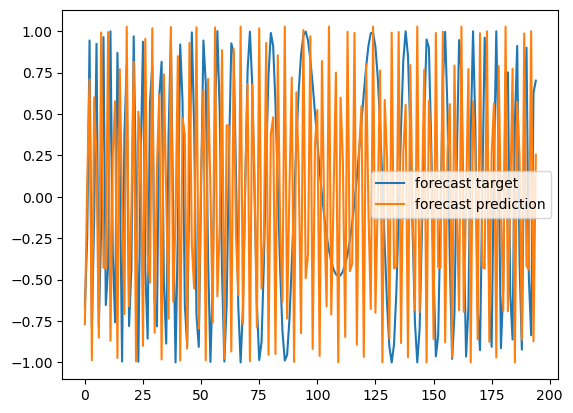

In [133]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()